In [1]:
%reset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
from mne import stats
from mne.viz import plot_compare_evokeds
import mne
from mne import create_info
from IPython.utils import io

In [3]:
all_subjects = np.array(
    ['08', '09', '10','11', '12','13', '14', '15', '16','17', '19', '20', '21', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34','35', '36', '37', '38'])
outlier_subs = ['12','14','15','17','27','30','34','36']
valid_subs = np.delete(all_subjects,np.isin(all_subjects,outlier_subs))
subs = valid_subs

subjectWithAllData = '08' # this subjects data will serve as a template for the data df

ch_names = ['E6','E7','E13','E106','E112']
info=create_info(ch_names=ch_names,ch_types='eeg',sfreq=250)

epochs_dir = 'C:\AnatArzData\YKM_data\epochs_and_evoked_allSubs'
prepro_name = "referenced"

## Import epochs

In [4]:
def getSubEpochsdata(sub_num):
    sub_load_filepath = f'{epochs_dir}\\epochs_sub{sub_num}_{prepro_name}_withElectorodes.mat'
    try:
        matlabImport = scipy.io.loadmat(sub_load_filepath, simplify_cells=True)
    except Exception:
        print(f'Error importing sub file at: {sub_load_filepath}')
        return

    epochs = matlabImport[
        'currSubEpochs']  # dim: vigilStage, elect, T/O/A, height , trialNum, sampleNum_in_cond ,timeSamples
    epochs = np.delete(epochs, 1, axis=0)  # reduce N1
    times = matlabImport['times']
    TOA = matlabImport['TOA']
    toneHieghts = matlabImport['toneHieghts']

    trialnums = matlabImport['trialnums']
    vigilance_states = matlabImport['vigilance_states']
    vigilance_states = np.delete(vigilance_states, 1)  # reduce N1

    electrodes = matlabImport['electrodes']
    sleep_states = matlabImport['sleep_states']
    sleep_states_eeglab = matlabImport['sleep_states_eeglab']
    wake_states = matlabImport['wake_states']
    vigilance_states_eeglab = matlabImport['vigilance_states_eeglab']

    return epochs, vigilance_states, electrodes,TOA, toneHieghts, trialnums, times
epochs, vigilance_states, electrodes, TOA, toneHeights, trialnums, times = getSubEpochsdata(subjectWithAllData)
time0_i = np.where(times==0)[0][0]

In [5]:
def getAllSubsEpochsDataAndMeta():
    epochs, vigilance_states, electrodes, TOA, toneHeights, trialnums, times = getSubEpochsdata(subjectWithAllData)

    # get the columns for the conditions table
    numOfRows = len(subs) * len(vigilance_states) * len(toneHeights) * len(TOA) * len(trialnums)
    metadata = np.zeros((numOfRows, 7), dtype=object)

    # populate table and with subject's conditions metadata and create an eeg data dictionary with condition as key
    full_data = {}
    curr_row_num = 0
    for sub_i, sub in enumerate(subs):
        try:
            epochs, vigilance_states, electrodes, TOA, toneHieghts, trialnums, times = getSubEpochsdata(sub)
        except TypeError:
            continue
        for ss_i, ss in enumerate(vigilance_states):
            for toneTy_i, toneTy in enumerate(TOA):
                for toneHi_i, toneHi in enumerate(toneHieghts):
                    for trial_i, trial in enumerate(trialnums):
                        curr_cond_epochs = epochs[ss_i, : ,toneTy_i, toneHi_i, trial_i, :, :]
                        curr_cond_epochs = curr_cond_epochs[~np.all(curr_cond_epochs == 0, axis=2)]  # removes 0 fillers rows
                        curr_cond_epochs=curr_cond_epochs.reshape((np.size(electrodes), -1,np.size(times)))
                        full_data[f"{curr_row_num}"] = curr_cond_epochs
                        sample_in_cond = curr_cond_epochs.shape[1]
                        metadata[curr_row_num, :] = [curr_row_num, sub, ss, toneTy, toneHi, trial, sample_in_cond]

                        curr_row_num += 1

    metadata = metadata[~np.all(metadata == 0, axis=1)]  # removes 0 fillers rows
    full_df = pd.DataFrame(metadata, columns=['Cond_id', 'Subject', 'Vigilance', 'TOA', 'ToneHeight', 'TrialPosition', 'SamplesAmount'])

    return full_data, full_df
full_data, full_df = getAllSubsEpochsDataAndMeta()

In [6]:
## add auxiliary columns
def TOA_type(row):
    if row['TOA'] == 'O' and (row['TrialPosition'] == '6' or row['TrialPosition'] == '7' or row['TrialPosition'] == '8'):
        return 'Rand'
    elif row['TOA'] == 'O' and row['TrialPosition']=='9':
        return 'Fixed'
    else:
        return row['TOA']

full_df['TOA_cond'] = full_df.apply(lambda row: TOA_type(row), axis=1)

In [7]:
full_df

,Cond_id,Subject,Vigilance,TOA,ToneHeight,TrialPosition,SamplesAmount,TOA_cond
0,0,08,Wn,T,650,0,24,T
1,1,08,Wn,T,650,1,24,T
2,2,08,Wn,T,650,2,24,T
3,3,08,Wn,T,650,3,24,T
4,4,08,Wn,T,650,4,24,T
...,...,...,...,...,...,...,...,...
22675,22675,38,REM,A,5302,5,0,A
22676,22676,38,REM,A,5302,6,0,A
22677,22677,38,REM,A,5302,7,0,A
22678,22678,38,REM,A,5302,8,0,A


In [8]:
def getAllSampData(df):
    df_minTrials = df[(df.SamplesAmount > 0)] # discard cond with 0 enough samples

    minTrials_cond_keys = np.asarray([str (i) for i in df_minTrials['Cond_id']])
    epochs_allSamples = {}
    evokeds_allSamples = {}

    for key in minTrials_cond_keys:
        epochs_allSamples[key] = full_data[key]
        evokeds_allSamples[key] = np.nanmean(full_data[key],axis=0)
    return df_minTrials, epochs_allSamples, evokeds_allSamples

In [9]:
# output: [#electrods, times]
def get_avgOverTrials(df, conditions):
    curr_df =df.copy()
    for key in conditions:
            curr_df = curr_df[(curr_df[key] == conditions[key])]

    currDf_samps, epochs_samps, evokeds_samps = getAllSampData(curr_df)

    avgOverTrial_perCond = np.zeros((len(epochs_samps),np.size(electrodes),np.size(times)))

    for cond_i, cond in enumerate(epochs_samps):
        avgOverTrial_perCond[cond_i] = np.squeeze(np.mean(epochs_samps[cond],1))

    return np.squeeze(np.mean(avgOverTrial_perCond, 0))

## Clusters and evoked funcs

In [ ]:
def getClustersPerConditions(df, startTime_i, contrastTypeName,contrasts,conditions):
    cluster_subjs = [] # list (size subs) of list (size pairs) of 138 samps each
    for s,subject in enumerate(subs):
        cluster_pair = []
        conditions['Subject'] = subject
        for pair in contrasts: # averaged across trials
            conditions[contrastTypeName] = pair[0]
            meanOverTrials_first = get_avgOverTrials(df, conditions)
            conditions[contrastTypeName] = pair[1]
            meanOverTrials_sec = get_avgOverTrials(df, conditions)
            diff_sub_pair_mean = np.mean(meanOverTrials_first - meanOverTrials_sec, axis=0)
            if ~np.all(diff_sub_pair_mean==0):
                cluster_pair.append(diff_sub_pair_mean)
        cluster_subjs.append(cluster_pair)

    """ Perform cluster permutation (paired t-test) """
    cluster_res={}
    for n, pair in enumerate(contrasts):
        curr_pair_res ={}
        curr_pair_res['T_obs'], curr_pair_res['clusters_equal'],curr_pair_res['cluster_equal_pv'],curr_pair_res['H0'] = stats.permutation_cluster_1samp_test(np.asarray(cluster_subjs)[:,n,startTime_i:],n_permutations=10000, buffer_size=None)

        cluster_res[f"{pair[0]}_{pair[1]}"] = curr_pair_res

    return cluster_res

In [11]:
""" create a df with the clusters details"""
#bonferroni correction (0.05/6)=0.0083
def get_clusters_dfs(contrasts, times, cluster_res,p_crit = 0.05):
    comparison = []
    p_values = []
    start = []
    end = []
    for s,pair in enumerate(contrasts):
        comparison_level = []
        start_level = []
        end_level = []

        contrast_str = f"{pair[0]}_{pair[1]}"
        curr_cluster_equal = cluster_res[contrast_str]['clusters_equal']
        curr_cluster_equal_pv = cluster_res[contrast_str]['cluster_equal_pv']
        cluster_res[contrast_str]['cl_'] = []

        if len(curr_cluster_equal)==0: continue
        for i_clu, clu_idx in enumerate(curr_cluster_equal):
            clu_idx = clu_idx[0]
            comparison_level.append(contrast_str)
            start_level.append(times[clu_idx[0]])
            end_level.append(times[clu_idx[-1]])
            if curr_cluster_equal_pv[i_clu] <= p_crit:
                cluster_res[contrast_str]['cl_'].append((times[clu_idx[0]],times[clu_idx[-1]]))
        comparison.append(comparison_level)
        start.append(start_level)
        end.append(end_level)
        p_values.append(list(curr_cluster_equal_pv))

    # Create dataframe
    comparison = np.concatenate(comparison)
    p_values = np.concatenate(p_values)
    start = np.concatenate(start)
    end = np.concatenate(end)
    d = {'Comparison': comparison,'p-value': p_values,'start (ms)': start,'end (ms)': end}
    clusters = pd.DataFrame(data=d)

    sig_clus = clusters.drop(clusters[clusters['p-value']>p_crit].index)
    return clusters, sig_clus

In [12]:
def get_contrasts_ax(ax, contrasts, contrastsColors,cluster_res):
    for s,contrast in enumerate(contrasts):
        contrast_str = f"{contrast[0]}_{contrast[1]}"
        curr_cl = cluster_res[contrast_str]['cl_']
        for i in range(len(curr_cl)):
            ax.plot([curr_cl[i][0],curr_cl[i][1]], [-2-(s*0.1),-2-(s*0.1)],'-', color = contrastsColors[s][0], linewidth = 2.5)
            ax.plot([curr_cl[i][0],curr_cl[i][1]], [-2-(s*0.1),-2-(s*0.1)],'--', color = contrastsColors[s][1], linewidth = 2.5)

In [18]:
def getClustersPerConditions(df, startTime_i, contrastTypeName,contrasts,conditions):
    cluster_subjs = [] # list (size subs) of list (size pairs) of 138 samps each
    for s,subject in enumerate(subs):
        cluster_pair = []
        conditions['Subject'] = subject
        for pair in contrasts: # averaged across trials
            conditions[contrastTypeName] = pair[0]
            meanOverTrials_first = get_avgOverTrials(df, conditions)
            conditions[contrastTypeName] = pair[1]
            meanOverTrials_sec = get_avgOverTrials(df, conditions)
            diff_sub_pair_mean = np.mean(meanOverTrials_first - meanOverTrials_sec, axis=0)
            if ~np.all(diff_sub_pair_mean==0):
                cluster_pair.append(diff_sub_pair_mean)
        cluster_subjs.append(cluster_pair)

    """ Perform cluster permutation (paired t-test) """
    cluster_res={}
    for n, pair in enumerate(contrasts):
        curr_pair_res ={}
        curr_pair_res['T_obs'], curr_pair_res['clusters_equal'],curr_pair_res['cluster_equal_pv'],curr_pair_res['H0'] = stats.permutation_cluster_1samp_test(np.asarray(cluster_subjs)[:,n,startTime_i:],n_permutations=10000, buffer_size=None)

        cluster_res[f"{pair[0]}_{pair[1]}"] = curr_pair_res

    return cluster_res

In [14]:
# def get_evokedPerCond_ax_mneFunc(ax1,df,condName : str, condVaribles, filterConds, graphColors):
#     evokeds = {}
#     for s,subject in enumerate(subs):
#         evokeds[s] = {}
#         filterConds['Subject'] = subject
#         for val in condVaribles:
#             filterConds[condName] = val
#             curr_subAndCond_electrOverTime = get_avgOverTrials(df, filterConds)
#             curr_subAndCond_electrOverTime /= 1e6
#             evokeds[s][val] = mne.EvokedArray(curr_subAndCond_electrOverTime,info,tmin=-0.1)
#
#     # Edit the data to mne plot format
#     evokeds_mnePlotFormat = {}
#     for val in condVaribles:
#         evokeds_mnePlotFormat[val] = []
#         for sub_i in range(len(subs)):
#             evokeds_mnePlotFormat[val].append(evokeds[sub_i][val])
#
#     plot_compare_evokeds(evokeds_mnePlotFormat,combine = 'mean',colors=graphColors,
#                          axes=ax1,show=False,truncate_xaxis=False, truncate_yaxis=False,
#                          show_sensors = False , legend='upper left')
def applyDesign(ax,title='',y_lims=[-3,3]):
    ax.set_facecolor('silver')
    ax.set_title(title,fontsize = 18, fontweight = 'bold')
    ax.legend(loc = 'upper left',prop={'size': 10})
    ax.axvline(x=0,color='gray', linestyle='--',label ="_nolegend_")
    ax.axhline(y=0, color='gray', linestyle='-',label ="_nolegend_")
    ax.set_ylabel('\u03BCV', fontsize = 16, fontweight = 'bold')
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Time (ms)', fontsize = 16, fontweight = 'bold')
    ax.set_xlim([-100,450])
    ax.set_ylim(y_lims)
    ax.text(-0.02, y_lims[1], 'stimulus', rotation=90, va='center', fontsize = 13)

def get_evokedPerCond_ax(ax1,df,condName : str, condVaribles, filterConds, graphColors):
    all_evokeds = np.zeros((len(subs),len(condVaribles) , len(times)))
    for s,subject in enumerate(subs):
        filterConds['Subject'] = subject
        for v,val in enumerate(condVaribles):
            filterConds[condName] = val
            curr_subAndCond_electrOverTime = get_avgOverTrials(df, filterConds)
            all_evokeds[s,v,:] = np.mean(curr_subAndCond_electrOverTime,axis=0)

    mean_ = np.mean(all_evokeds,axis=0)
    std_ = np.nanstd(all_evokeds/np.sqrt(all_evokeds.shape[0]),axis=0)

    ax1.plot(times,mean_.T)
    for v,val in enumerate(condVaribles):
        ax1.fill_between(times,mean_[v]+std_[v] ,mean_[v]-std_[v], color=graphColors[v],alpha=0.1,label ="_nolegend_")
        ax1.plot(times,mean_[v],label = condVaribles[v],color=graphColors[v])
    return ax1

# Resutls

In [22]:
contrasts = [['Wn','N2'],['Wn','N3'],['Wn','REM'],['N2','N3'],['N2','REM'],['REM','N3']]
contrastsColors = [['blue', 'orange'], ['blue', 'green'], ['blue', 'red'], ['orange', 'green'], ['orange', 'red'], ['red', 'green']]
contrastTypeName = 'Vigilance'
contrast_seperateVal = ['Wn','N2','N3','REM']
contrasts_sep_colors = ['blue', 'orange', 'green', 'red']

filters= {'TOA_cond':'T'}
filters_string = f"{filters}"

### get df cluster info
with io.capture_output() as captured: # suppress output
    cluster_res = getClustersPerConditions(full_df, time0_i,contrastTypeName,contrasts,filters)
    all_clust_df, sig_clust_df = get_clusters_dfs(contrasts,times[time0_i:],cluster_res)
    display(all_clust_df)
    display(sig_clust_df)
### plot clusters
fig,ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1 = get_evokedPerCond_ax(ax1, full_df, contrastTypeName, contrast_seperateVal, filters, contrasts_sep_colors)
get_contrasts_ax(ax1, contrasts, contrastsColors,cluster_res)
applyDesign(ax1,f'Temporal cluster permutation\n{filters_string} \noutliers:{outlier_subs}')

Using a threshold of 2.085963
stat_fun(H1): min=-7.981481 max=6.608526
Running initial clustering
Found 3 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


KeyboardInterrupt: 

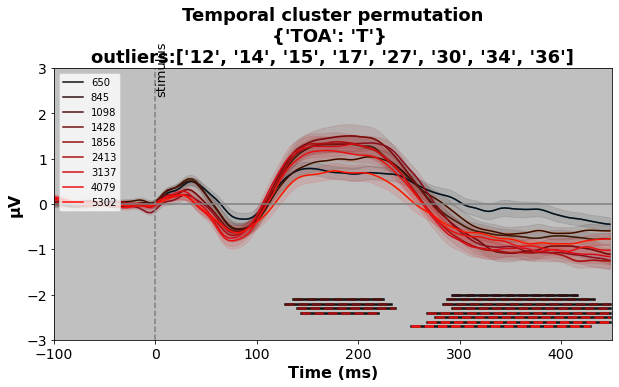

In [16]:
contrasts_sep_colors = ['#0f0f0f','#2f0f0f','#4f0f0f','#6f0f0f','#8f0f0f','#af0f0f','#cf0f0f','#ef0f0f','#ff0f0f']
contrastsColors = [[contrasts_sep_colors[0], contrasts_sep_colors[1]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[2]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[3]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[4]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[5]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[6]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[7]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[8]]]
contrastTypeName = 'ToneHeight'
contrasts = [['650','845'],['650','1098'],['650','1428'],['650','1856'],['650','2413'],['650','3137'],['650','4079'],['650','5302']]
contrast_seperateVal = ['650','845','1098','1428','1856','2413','3137','4079','5302']

filters= {'TOA':'T'}
filters_string = f"{filters}"

### get df cluster info
with io.capture_output() as captured: # suppress output
    cluster_res = getClustersPerConditions(full_df, time0_i,contrastTypeName,contrasts,filters)
    all_clust_df, sig_clust_df = get_clusters_dfs(contrasts,times[time0_i:],cluster_res)
    display(all_clust_df)
    display(sig_clust_df)
### plot clusters
fig,ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1 = get_evokedPerCond_ax(ax1, full_df, contrastTypeName, contrast_seperateVal, filters, contrasts_sep_colors)
get_contrasts_ax(ax1, contrasts, contrastsColors,cluster_res)
applyDesign(ax1,f'Temporal cluster permutation\n{filters_string} \noutliers:{outlier_subs}')

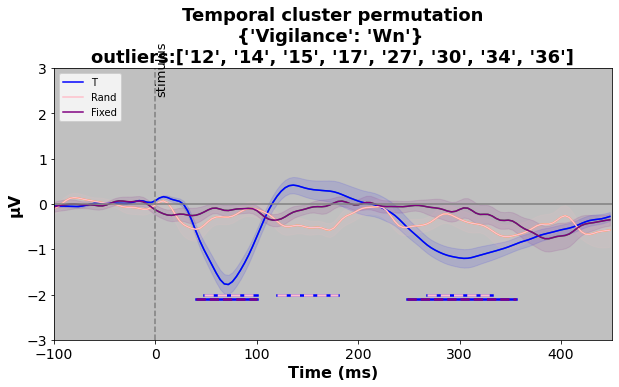

In [17]:
contrasts = [['T','Rand'],['T','Fixed'],['Rand','Fixed']]
contrastsColors = [ ['blue', 'pink'], ['blue', 'purple'],['purple', 'pink']]
contrastTypeName = 'TOA_cond'
contrast_seperateVal = ['T','Rand','Fixed']
contrasts_sep_colors = ['blue','pink','purple']

filters= {'Vigilance':'Wn'}
filters_string = f"{filters}"

### get df cluster info
with io.capture_output() as captured: # suppress output
    cluster_res = getClustersPerConditions(full_df, time0_i,contrastTypeName,contrasts,filters)
    all_clust_df, sig_clust_df = get_clusters_dfs(contrasts,times[time0_i:],cluster_res)
    display(all_clust_df)
    display(sig_clust_df)

### plot clusters
fig,ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1 = get_evokedPerCond_ax(ax1, full_df, contrastTypeName, contrast_seperateVal, filters, contrasts_sep_colors)
get_contrasts_ax(ax1, contrasts, contrastsColors,cluster_res)
applyDesign(ax1,f'Temporal cluster permutation\n{filters_string} \noutliers:{outlier_subs}')